I acknowledge to have used the explain error option available in Google Colab to help with debugging.

In [ ]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
# setting the seed values to my student id (for reproducability)
set_seed_val = 1898948
tf.random.set_seed(set_seed_val)
np.random.seed(set_seed_val)
random.seed(set_seed_val)

In [ ]:
#Data Preprocessing
def load_and_preprocess_data(file_path, sequence_length=30):
    """
    This method loads and preprocesses the dataset. and in doing so does the following:
    - Converts the date column to datetime and sorts the data by date.
    - Cleans and converts 'Close' and 'Volume' columns to numeric values.
    - Normalizes features using MinMaxScaler.
    - Creates sequences of data for time-series prediction.

    It takes the following parameters:
    - file_path: Path to the CSV file containing the data.
    - sequence_length: Number of past days to use for creating input sequences.

    and returns
    - X: Input sequences.
    - y: Target values (Close prices).
    - scaler: MinMaxScaler object to inverse transform predictions later.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Converting the 'Date' column to datetime format and sorting by date
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date')

    # Cleaning and converting 'Close' and 'Volume' columns to numeric. These columns have data in the format " eg: 100.89"
    data['Close'] = data['Close'].replace(',', '', regex=True).astype(float)
    data['Volume'] = data['Volume'].replace(',', '', regex=True).astype(float)

    # Normalizing the all numeric features (Open, High, Low, Close, Volume)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

    # Adjusting sequence length for limited data.
    # This is done because the test dataset has very few data and using the default 30 length sequence leads to error
    adjusted_sequence_length = min(sequence_length, len(data) - 1)

    # Creating the input sequences and target values
    X, y = create_sequences(scaled_data, adjusted_sequence_length, target_index=3)  # Target is 'Close' (index 3). Reasoning given in the report
    return X, y, scaler



In [ ]:
def create_sequences(data, sequence_length, target_index):
    """
    This method creates sequences of past data for time-series prediction.

    Its parameters are:
    - data: Normalized dataset as a NumPy array.
    - sequence_length: Number of past days to consider in each sequence.
    - target_index: Index of the target column in the data. (Close for this project)

    It returns:
    - X: Array of input sequences.
    - y: Array of corresponding target values.
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])  # Using the past 'sequence_length' days as input
        y.append(data[i, target_index])  # Predicting the value at the current day
    return np.array(X), np.array(y)


In [ ]:
def build_model(model_type, input_shape, output_units, num_layers=1, dropout_rate=0.2, learning_rate=0.001):
    """
    This method is used to dynamically builds RNN models with specified parameters.

    its parameters:
    - model_type: RNN class (e.g., SimpleRNN, LSTM, GRU).
    - input_shape: Shape of the input data (sequence_length, num_features).
    - output_units: Number of output units (e.g., 1 for single value prediction).
    - num_layers: Number of RNN layers in the model.
    - dropout_rate: Dropout rate for regularization.
    - learning_rate: Learning rate for the optimizer.

    Returns:
    - Keras model.
    """
    model = Sequential()
    for i in range(num_layers):
        # Adding the RNN layers dynamically based on the specified number of layers
        return_sequences = True if i < num_layers - 1 else False
        model.add(model_type(units=50, input_shape=input_shape if i == 0 else None, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))  # Dropout for regularization
        if i < num_layers - 1:
            model.add(BatchNormalization())  # Normalizing intermediate layer outputs

    # Adding the dense layers for regression output
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=output_units))  # this is the final output layer
    # specifying the optimizer, metric and the loss
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """
    This method is used to train the model with early stopping so that overfitting is prevented.

    its parameters are:
    - model: Keras model that we need to train.
    - X_train: Training data (input sequences).
    - y_train: Training labels (target values).
    - X_val: Validation data (input sequences).
    - y_val: Validation labels (target values).
    - epochs: Number of training epochs.
    - batch_size: Batch size for gradient updates.

    it returns:
    - Training history containing loss and validation loss over epochs.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return history


In [ ]:
def grid_search(X_train, y_train, X_val, y_val, input_shape):
    """
    Using this method we perform the grid search over hyperparameters.

    Its parameters are:
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - input_shape: Shape of the input data.

    It returns:
    - List of results, sorted by validation loss.
    """
    results = []
    param_grid = {
        'model_type': [SimpleRNN, LSTM, GRU],
        'learning_rate': [0.001, 0.01],
        'dropout_rate': [0.2, 0.3],
        'num_layers': [1, 2]
    }
    # Iterating through all combinations of hyperparameters
    for model_type in param_grid['model_type']:
        for learning_rate in param_grid['learning_rate']:
            for dropout_rate in param_grid['dropout_rate']:
                for num_layers in param_grid['num_layers']:
                    print(f"Training: {model_type.__name__}, LR: {learning_rate}, Dropout: {dropout_rate}, Layers: {num_layers}")

                    # Building and training the model with the current hyperparameters set
                    model = build_model(
                        model_type=model_type,
                        input_shape=input_shape,
                        output_units=1,
                        num_layers=num_layers,
                        dropout_rate=dropout_rate,
                        learning_rate=learning_rate
                    )

                    history = train_model(model, X_train, y_train, X_val, y_val)
                    final_val_loss = min(history.history['val_loss'])  # Tracking the lowest validation loss

                    results.append({
                        'model_type': model_type.__name__,
                        'learning_rate': learning_rate,
                        'dropout_rate': dropout_rate,
                        'num_layers': num_layers,
                        'final_val_loss': final_val_loss,
                        'history': history,  # Including the training history object that can be used for visualization for the report
                        'model': model
                    })

    # Sorting the results by validation loss
    results = sorted(results, key=lambda x: x['final_val_loss'])
    return results

In [ ]:
def evaluate_and_predict(model, X_test, y_test, scaler):
    """
    this method evaluates the model and generates predictions.
     We also need to handle the mismatched dimensions for inverse transformation.
    """
    # Predicting using the model
    predictions = model.predict(X_test)

    # inverse transformation placeholder
    placeholder = np.zeros((predictions.shape[0], scaler.scale_.shape[0]))
    placeholder[:, 3] = predictions[:, 0]  # Populating the column of choice i.e the 'Close' column

    # Inverse transform only the 'Close' column as that is what we are predicting
    predictions_original = scaler.inverse_transform(placeholder)[:, 3]

    # Same process for the true values aas well
    placeholder = np.zeros((y_test.shape[0], scaler.scale_.shape[0]))
    placeholder[:, 3] = y_test
    y_test_original = scaler.inverse_transform(placeholder)[:, 3]

    return predictions_original, y_test_original

In [ ]:
# Loading and preprocessing data that was mounted in the Google Drive
sequence_length = 30
X_train, y_train, scaler = load_and_preprocess_data('/content/drive/MyDrive/data/Google_Stock_Price_Train.csv', sequence_length)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Performing the grid search for best hyperparameter combination
input_shape = (X_train.shape[1], X_train.shape[2])
results = grid_search(X_train, y_train, X_val, y_val, input_shape)

# Selecting the best model based on validation loss
best_model_info = results[0]
best_model = best_model_info['model']
print(f"Best Model: {best_model_info}")


Training: SimpleRNN, LR: 0.001, Dropout: 0.2, Layers: 1
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0397 - mae: 0.1515 - val_loss: 0.0052 - val_mae: 0.0571
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0708 - val_loss: 0.0031 - val_mae: 0.0438
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mae: 0.0568 - val_loss: 0.0016 - val_mae: 0.0270
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0536 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0455 - val_loss: 0.0018 - val_mae: 0.0319
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0467 - val_loss: 0.0015 - val_mae: 0.0282
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0438 - val_loss: 9.8632e-04 - val_mae: 0.0216
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0384 - val_loss: 9.2987e-04 - val_mae: 0.0219
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0

In [ ]:
# Summary result for the purpose of using in the report
results_df = pd.DataFrame([
    {
        'Model Type': result['model_type'],
        'Learning Rate': result['learning_rate'],
        'Dropout Rate': result['dropout_rate'],
        'Num Layers': result['num_layers'],
        'Final Validation Loss': result['final_val_loss']
    }
    for result in results
])

print(results_df)

# Saving the summary as CSV file
results_df.to_csv('model_training_summary.csv', index=False)

   Model Type  Learning Rate  Dropout Rate  Num Layers  Final Validation Loss
0         GRU          0.001           0.2           1               0.000265
1         GRU          0.010           0.2           1               0.000296
2         GRU          0.010           0.3           1               0.000303
3        LSTM          0.010           0.2           1               0.000338
4   SimpleRNN          0.010           0.2           1               0.000343
5   SimpleRNN          0.010           0.3           1               0.000385
6         GRU          0.001           0.3           1               0.000402
7        LSTM          0.001           0.2           1               0.000423
8   SimpleRNN          0.001           0.2           1               0.000448
9        LSTM          0.010           0.3           1               0.000532
10       LSTM          0.001           0.3           1               0.000580
11  SimpleRNN          0.001           0.3           1          

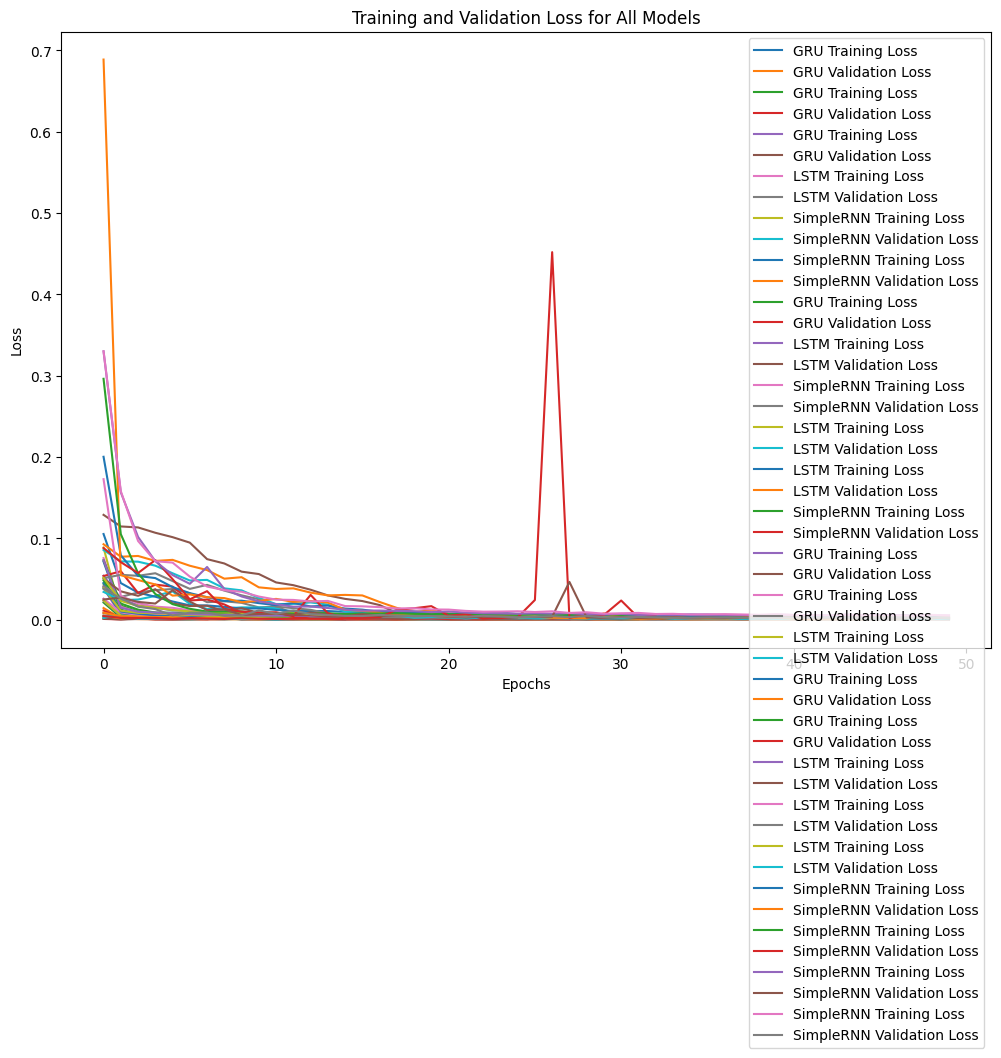

In [ ]:
def plot_all_training_histories(results):
    """
    Plotting the training and validation loss for all models.
    """
    plt.figure(figsize=(12, 8))
    for result in results:
        history = result['history']
        model_name = result['model_type']
        plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')

    plt.title('Training and Validation Loss for All Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_all_training_histories(results)


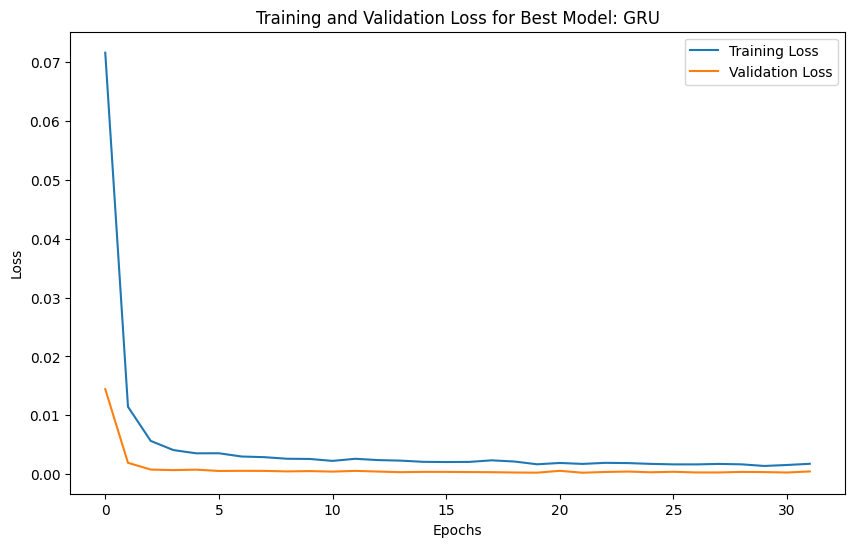

In [ ]:
def plot_best_model_training(best_model_result):
    """
    Plotting  the training and validation loss for the best model. which is a GRU model
    """
    history = best_model_result['history']
    model_name = best_model_result['model_type']
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Best Model: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Finding the best model based on the final valiadtion loss
best_model_result = min(results, key=lambda x: x['final_val_loss'])

plot_best_model_training(best_model_result)


In [ ]:
# checking the test data as initially I was getting an error caused by the sequence length

_test, y_test, _ = load_and_preprocess_data('/content/drive/MyDrive/data/Google_Stock_Price_Test.csv', sequence_length=30)

print(f"Number of sequences in test data: {len(X_test)}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Number of sequences in test data: 15
Shape of X_test: (15, 5, 5)
Shape of y_test: (1,)


In [ ]:
# Loading and preprocessing test data. The sequence lenght here is 5 as the test dataset is very limited
X_test, y_test, _ = load_and_preprocess_data('/content/drive/MyDrive/data/Google_Stock_Price_Test.csv', sequence_length=5)

# Evaluating using the best model
predictions, y_test_original = evaluate_and_predict(best_model, X_test, y_test, scaler)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


In [ ]:
print(predictions, y_test_original)

[ 791.52979269  790.84990988  808.12196951  796.52901497  815.57617879
  782.78134293  781.79669252  749.47411343  762.97945058  925.00813872
 1042.80413424 1202.41178734 1209.63905906 1076.27835553  755.45366103] [ 764.42833636  810.13731274  787.42932768  809.69780335  761.79128003
  783.18073693  726.04451645  767.79790834  977.15088027 1043.95630729
 1216.83       1165.26089845 1035.75213204  728.2420634   647.22583283]


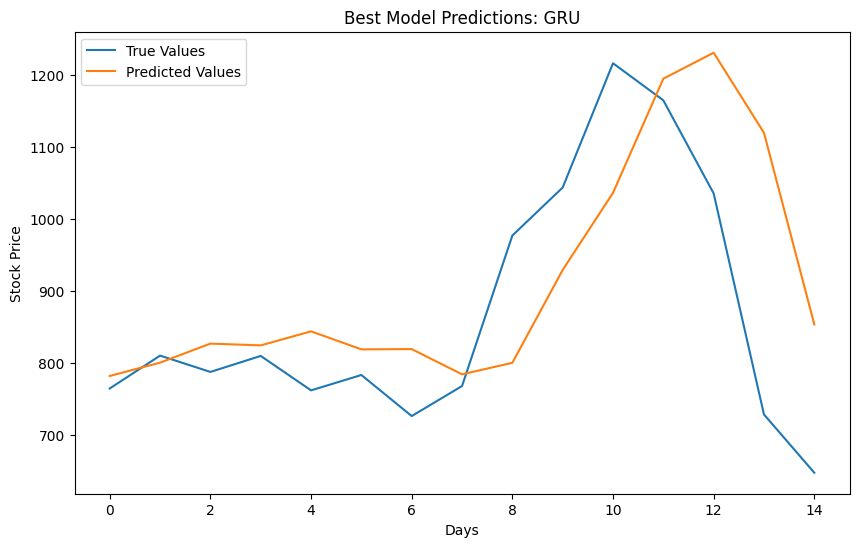

In [ ]:
# Plotting the predictions and the true values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title(f"Best Model Predictions: {best_model_info['model_type']}")
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Calculating the evaluation metric MAE, MSE, and RMSE between predicted and true values (for test dataset)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [ ]:
mae, mse, rmse = calculate_metrics(y_test_original, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 106.95300978054027
Mean Squared Error (MSE): 22092.23142315127
Root Mean Squared Error (RMSE): 148.63455662513772
